In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def brownianmotion(time, timestep, number=1):
    steps = int(time/timestep)
    t = np.arange(0, time, timestep)
    Bt = np.random.normal(loc=0, scale=np.sqrt(timestep), size=(number, steps-1))
    Bt = np.hstack((np.zeros((Bt.shape[0], 1)), Bt))
    Bt = np.cumsum(Bt, axis=1)
    # Add option to export the original white noise (used to make Bt) aswell. Useful for stochastic integrals.
    return t, Bt

def geometricbrownianmotion(time, timestep, mu, sigma, s0=1):
    t, Bt = brownianmotion(time, timestep)
    Xt = s0 * np.exp((mu-sigma**2/2)*t + sigma*y)
    return t, Xt

def poissonprocess(rate, size, number=1):
    x = np.array(range(size+1))
    y = np.cumsum(np.random.exponential(rate, size=[number, size]), axis=1)
    y = np.hstack((np.zeros((number, 1)), y)) 
    return x, y, rate

def plot_mean(t, Xt):
    Xt_mean = np.mean(Xt, axis=0)
    plt.plot(t, Xt_mean, color="black")

def plot_var(t, Xt):
    Xt_mean = np.var(Xt, axis=0)
    plt.plot(t, Xt_mean, color="black")

def plot_solution(t, Xt, num_max=50, alpha=0.4, with_mean=False, with_var=False, color=None):
    for i in range(min(Xt.shape[0], num_max)):
        plt.plot(t, Xt[i], alpha=alpha, color=color)
    
    if with_mean:
        plot_mean(t, Xt)

    if with_var:
        plot_var(t, Xt)

def stochastic_integral(time, dt, num, fun):
    """Computes samples of the stochastic integral w.r.t. Bt. Requires a function f(t,x) as input (x=Xt)"""
    t, Bt = brownianmotion(time, dt, num)
    dBt = np.hstack((np.diff(Bt), np.zeros((Bt.shape[0], 1)))) 
    Xt = np.cumsum(fun(t, Bt) * dBt, axis=1)
    return t, Xt

def f_ornstein(t,x):
    """Mean function of Ornstein-Uhlenbeck process"""
    return 0.7*(1.5-x)

def g_ornstein(t,x):
    """Variance function of Ornstein-Uhlenbeck process"""
    return 0.06

def solve_sde(time, dt, f_func=f_ornstein, g_func=g_ornstein, num=50):
    """Enter a SDE in the form dX(t)=f(t,Xt)X(t)dt + g(t,Xt)dB(t)"""

    t, Bt = brownianmotion(time, dt, num)
    dBt = np.hstack((np.diff(Bt), np.zeros((Bt.shape[0], 1)))) 

    Xt = np.full_like(Bt, fill_value=0) 

    for i in range(1, Bt.shape[1]):
        Xt[:,i] = Xt[:,i-1] + f_func(t[i-1],Xt[:,i-1])*dt + g_func(t[i-1],Xt[:,i-1])*dBt[:,i]

    return t, Xt

# Feynman-kac
# Bessel process

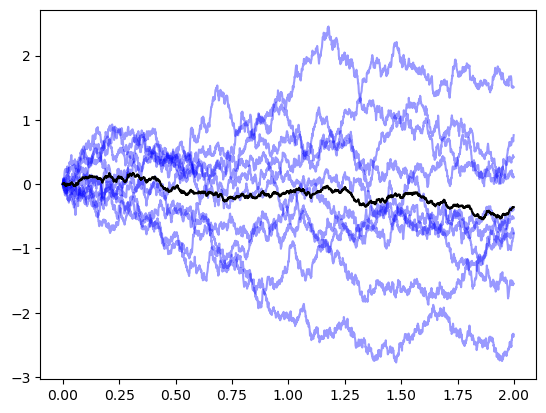

In [3]:
t, Bt = brownianmotion(2, 0.001, 10)
plot_solution(t, Bt, with_mean=True, color='blue')

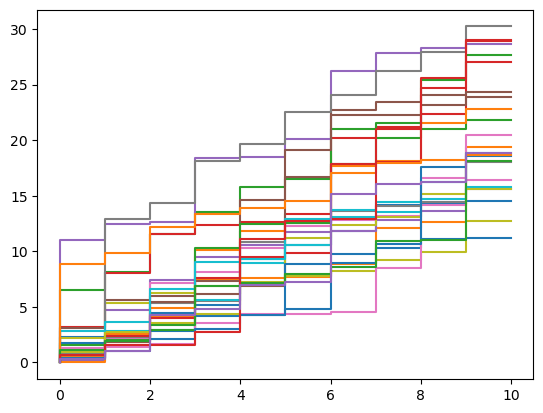

In [4]:
x, y, _ = poissonprocess(2, 10, 25)
for i in range(y.shape[0]):
    plt.step(x, y[i])

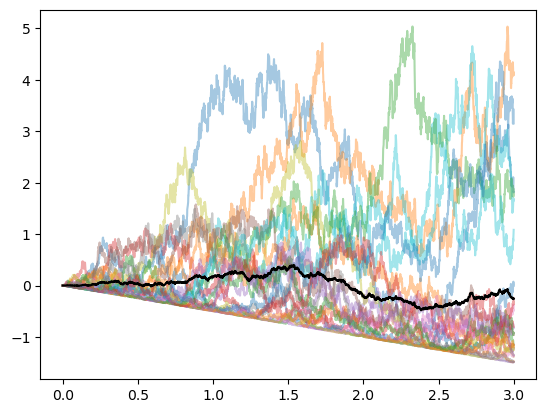

In [5]:
t, Bt = brownianmotion(3, 0.001, 25)
intBtdBt = (Bt**2 - t)/2

plot_solution(t, intBtdBt, with_mean=True)

In [ ]:
1

From here, we will try to numerically compute the stochastic intergral, starting by $\int_0^tB_tdB_t$. Above, we see samples of the analytical solution

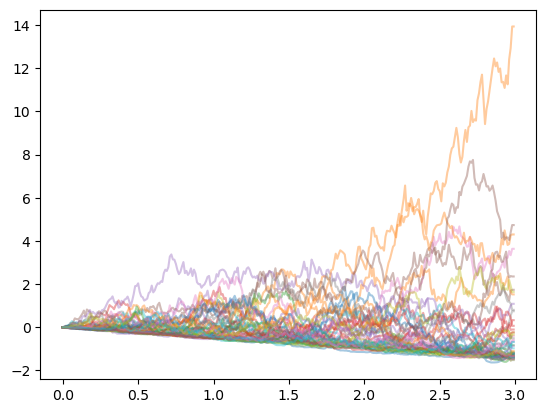

In [6]:
def f_func(t, x):
    return np.exp(x-t/2)

def f_func(t, x):
    return x

t, Xt = stochastic_integral(3, 0.01, 50, f_func)

plot_solution(t, Xt)

Solving the integral $\int_0^t\sin(t)dBt$.

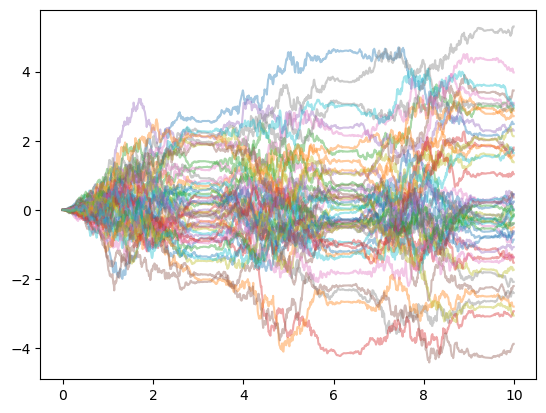

In [7]:
def f_func(t, x):
    return np.sin(t)

t, Xt = stochastic_integral(10, 0.01, 50, f_func)

plot_solution(t, Xt)

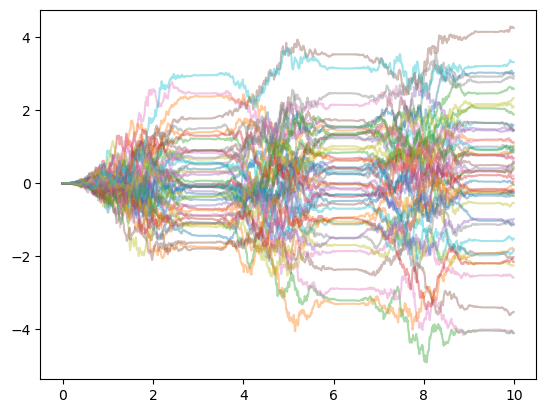

In [8]:
f_func = lambda t, x: np.sin(t)**2
t, Xt = stochastic_integral(10, 0.01, 50, f_func)

plot_solution(t, Xt)

Below, we solve Ornstein-Uhlenbeck SDE using numerical integration. First, we introduce the function solve_sde that solves SDE's of the form \
$dX_t = f(t,X_t)dt+g(t,X_t)dBt$. A special case is the OU SDE, given by:

$dX_t = \theta(\mu-X_t) dt + \sigma  dB_t$\
using the Euler-Mayurama scheme. The mean of the simulation agree with the analytical mean, hinting that the solution is correct.

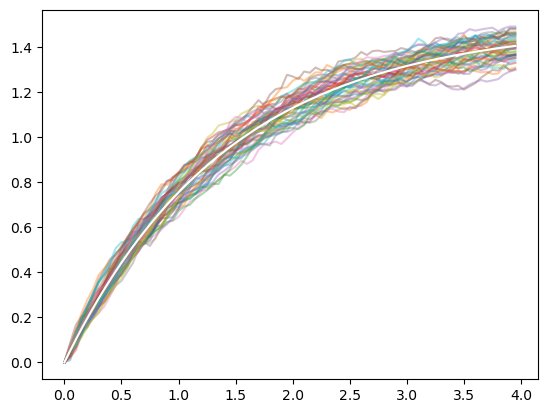

In [9]:
time=4
dt=0.05

mu=1.5
theta=0.7
t, Xt = solve_sde(time, dt, num=200)

plot_solution(t, Xt)
plt.plot(t, mu*(1-np.exp(-theta*t)), color='white')

We can input many functions. Here, for example we solve the SDE

$dX_t = t\sin(2t)dt + \log(t+1)dB_t$

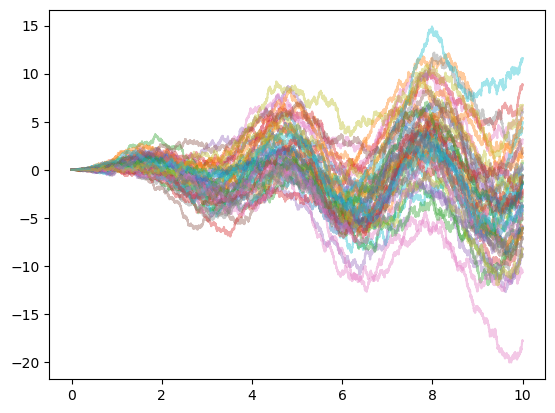

In [10]:
time=10
dt=0.001

def f_custom(t,x): 
    return t*np.sin(2*t)

def g_custom(t,x): 
    return np.log(t+1)

t, Xt = solve_sde(time, dt, f_func=f_custom, g_func=g_custom, num=500)
plot_solution(t, Xt, alpha=.4)

Or $dX_t=t(1-t/68)dt+10\log(t+1)dB_t$

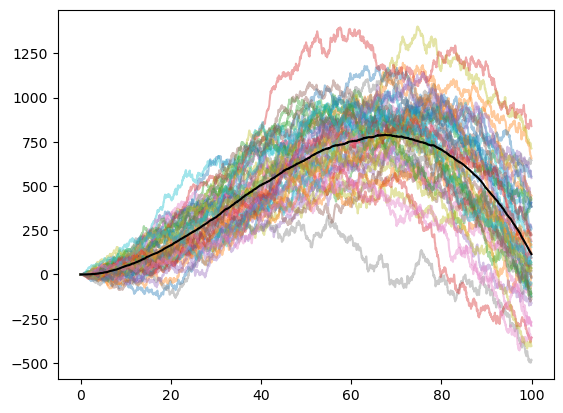

In [11]:
def f_custom(t,x):
    return t*(1-t/68)

def g_custom(t,x):
    return 10*np.log(1+t)

t, Xt = solve_sde(time=100, dt=0.05, f_func=f_custom, g_func=g_custom, num=250)

plot_solution(t, Xt, alpha=.4, with_mean=True)

Next we try to solve a system of two equations. This will be a modification of the predator-prey model. Typically, this is modeled as a Lotka-Volterra model

$\frac{dx}{dt}(t)=\alpha x -\beta x y\\
\frac{dy}{dt}(t)=\delta xy -\gamma y$

Which we can turn into a system of SDE's by adding a stochastic component randomly changing the quantity of both species, due to migration or death. These random processes will be proportional to the size of the colony: $\sigma_1X_tB^{(1)}_t$ and $\sigma_2Y_tB^{(2)}_t$:

$dX_t=(\alpha X_t -\beta X_t Y_t)dt + \sigma_1X_tdB^{(1)}_t\\
dY_t=(\delta X_tY_t -\gamma Y_t)dt + \sigma_2Y_tdB^{(2)}_t$

https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations

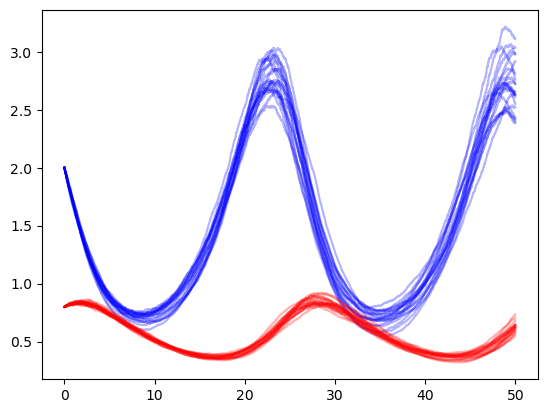

In [29]:
time=50
dt=0.01
num=20

t, Bt1 = brownianmotion(time, dt, num)
t, Bt2 = brownianmotion(time, dt, num)

dBt1 = np.hstack((np.diff(Bt1), np.zeros((Bt1.shape[0], 1)))) 
dBt2 = np.hstack((np.diff(Bt2), np.zeros((Bt2.shape[0], 1)))) 

alpha = 0.4
beta = 0.7
sigma1 = 0.01

delta=0.1
gamma=0.15
sigma2=0.01

Xt = np.full_like(Bt1, fill_value=2) 
Yt = np.full_like(Bt2, fill_value=0.8) 

for i in range(1, Bt1.shape[1]):
    Xt[:,i] = Xt[:,i-1] + (alpha*Xt[:,i-1] - beta*Xt[:,i-1]*Yt[:,i-1])*dt + sigma1*Xt[:,i-1]*dBt1[:,i]
    Yt[:,i] = Yt[:,i-1] + (delta*Xt[:,i-1]*Yt[:,i-1] - gamma*Yt[:,i-1])*dt + sigma2*Yt[:,i-1]*dBt2[:,i]

plot_solution(t, Xt, alpha=.3, color="blue")
plot_solution(t, Yt, alpha=.3, color="red")

In [ ]:
np.random.laplace(loc=0, scale=1, size=10)

array([1.67761618, 1.82250524, 2.01492909, 2.54534072, 3.36888295,
       3.78381473, 3.87915063, 4.02503156, 4.59734251, 5.65159477])

In [31]:

timestep = 0.1
event_times = np.cumsum(np.random.exponential(2, size=[2, 6]), axis=1)
event_times_disc = np.round(event_times / timestep) * timestep

print(event_times)
print(event_times_disc)

[[ 1.83506932  2.81544203  5.03997754  6.80987448  6.86290044  6.93953228]
 [ 2.03336012  5.17807921  7.51125609  7.57948588 11.43296381 11.50785018]]
[[ 1.8  2.8  5.   6.8  6.9  6.9]
 [ 2.   5.2  7.5  7.6 11.4 11.5]]


In [53]:
t = np.arange(0, 10, 0.1)
y = np.zeros((2, t.shape[0]))

for idx, time in enumerate(t):
    y[:, idx] = np.sum(event_times_disc < time, axis=1)

print(y)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 6. 6.
  6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
  4. 4. 4. 4.]]


In [58]:
import matplotlib.pyplot as plt
from scipy.stats import poisson
poisson.ppf(0.997, 1.3)

ModuleNotFoundError: No module named 'scipy'